# Coursework D
### Exercises: Predicting Chaos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

In [ ]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """Transforms angles to Cartesian coordinates"""
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    return x1, y1, x2, y2

1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.

Epoch 1/50
15/15 [==============================] - 1s 2ms/step - loss: 1.1090
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 1.0236
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.9325
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.8271
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.7051
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.5792
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4683
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3923
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3571
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3450
Epoch 11/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 12/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3359
Epoch 13/50
15/15 [==============================

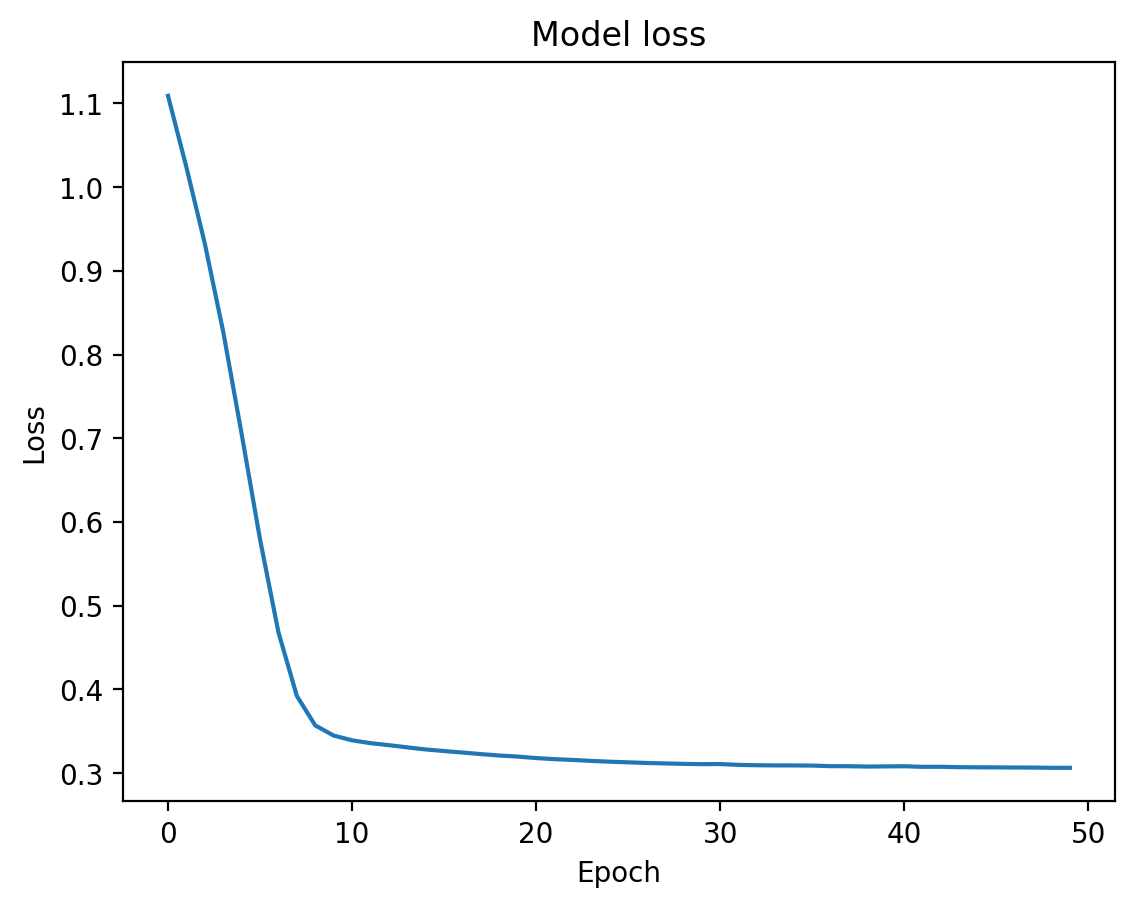

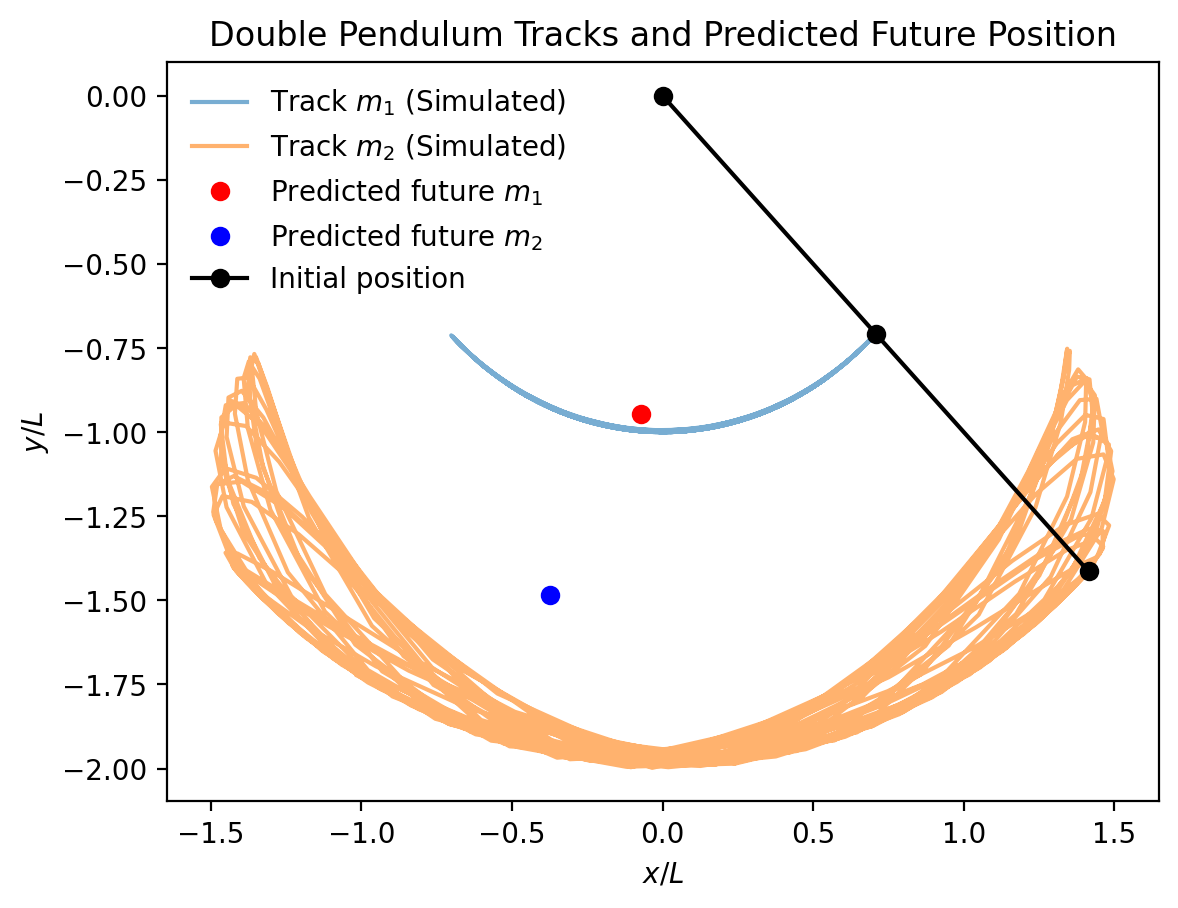

In [ ]:
# Parameters setup
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81
z0 = [np.pi/4, 0, np.pi/4, 0]
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)
sequence_length = 1 # Keep sequence length 1 for simplicity

# Generate training data
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45') # Use RK45 for more accurate simulation
z = ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1_data, y1_data, x2_data, y2_data = to_cartesian(theta1, w1, theta2, w2, L1, L2)
cartesian_data = np.stack([x1_data, y1_data, x2_data, y2_data], axis=1)

# Prepare data for LSTM
sequence_length = 1 # Each input is a single time step
future_step = 20 # Predict 20 steps into the future

X_train = []
y_train = []
for i in range(0, len(cartesian_data) - sequence_length - future_step):
    X_train.append(cartesian_data[i:i+sequence_length])
    y_train.append(cartesian_data[i+sequence_length+future_step])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape X_train for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 4))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
model.add(Dense(4)) # Output layer with 4 units for x1, y1, x2, y2

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

#loss = model.evaluate(X_val, y_val)

# Make a prediction
# To predict the position at t = t0 + 20*dt, starting from the last point in the training data:
last_input = cartesian_data[-sequence_length:].reshape((1, sequence_length, 4)) # Take the last sequence_length points and reshape
predicted_future_position = model.predict(last_input)

print("Predicted future position (x1, y1, x2, y2) at t = t0 + 20*dt:", predicted_future_position)


# Plot the training history (loss)
plt.figure()
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot the tracks and the predicted future position
fig, ax = plt.subplots()
ax.plot(x1_data, y1_data, label=r"Track $m_1$ (Simulated)", alpha=0.6)
ax.plot(x2_data, y2_data, label=r"Track $m_2$ (Simulated)", alpha=0.6)
ax.plot(predicted_future_position[0, 0], predicted_future_position[0, 1], 'ro', label='Predicted future $m_1$')
ax.plot(predicted_future_position[0, 2], predicted_future_position[0, 3], 'bo', label='Predicted future $m_2$')
ax.plot([0, x1_data[0], x2_data[0]], [0, y1_data[0], y2_data[0]], "-o", label="Initial position", c='k')
ax.set_ylabel(r"$y/L$")
ax.set_xlabel(r"$x/L$")
ax.legend()
plt.title('Double Pendulum Tracks and Predicted Future Position')
plt.show()

2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

1/1 [==============================] - 0s 22ms/step


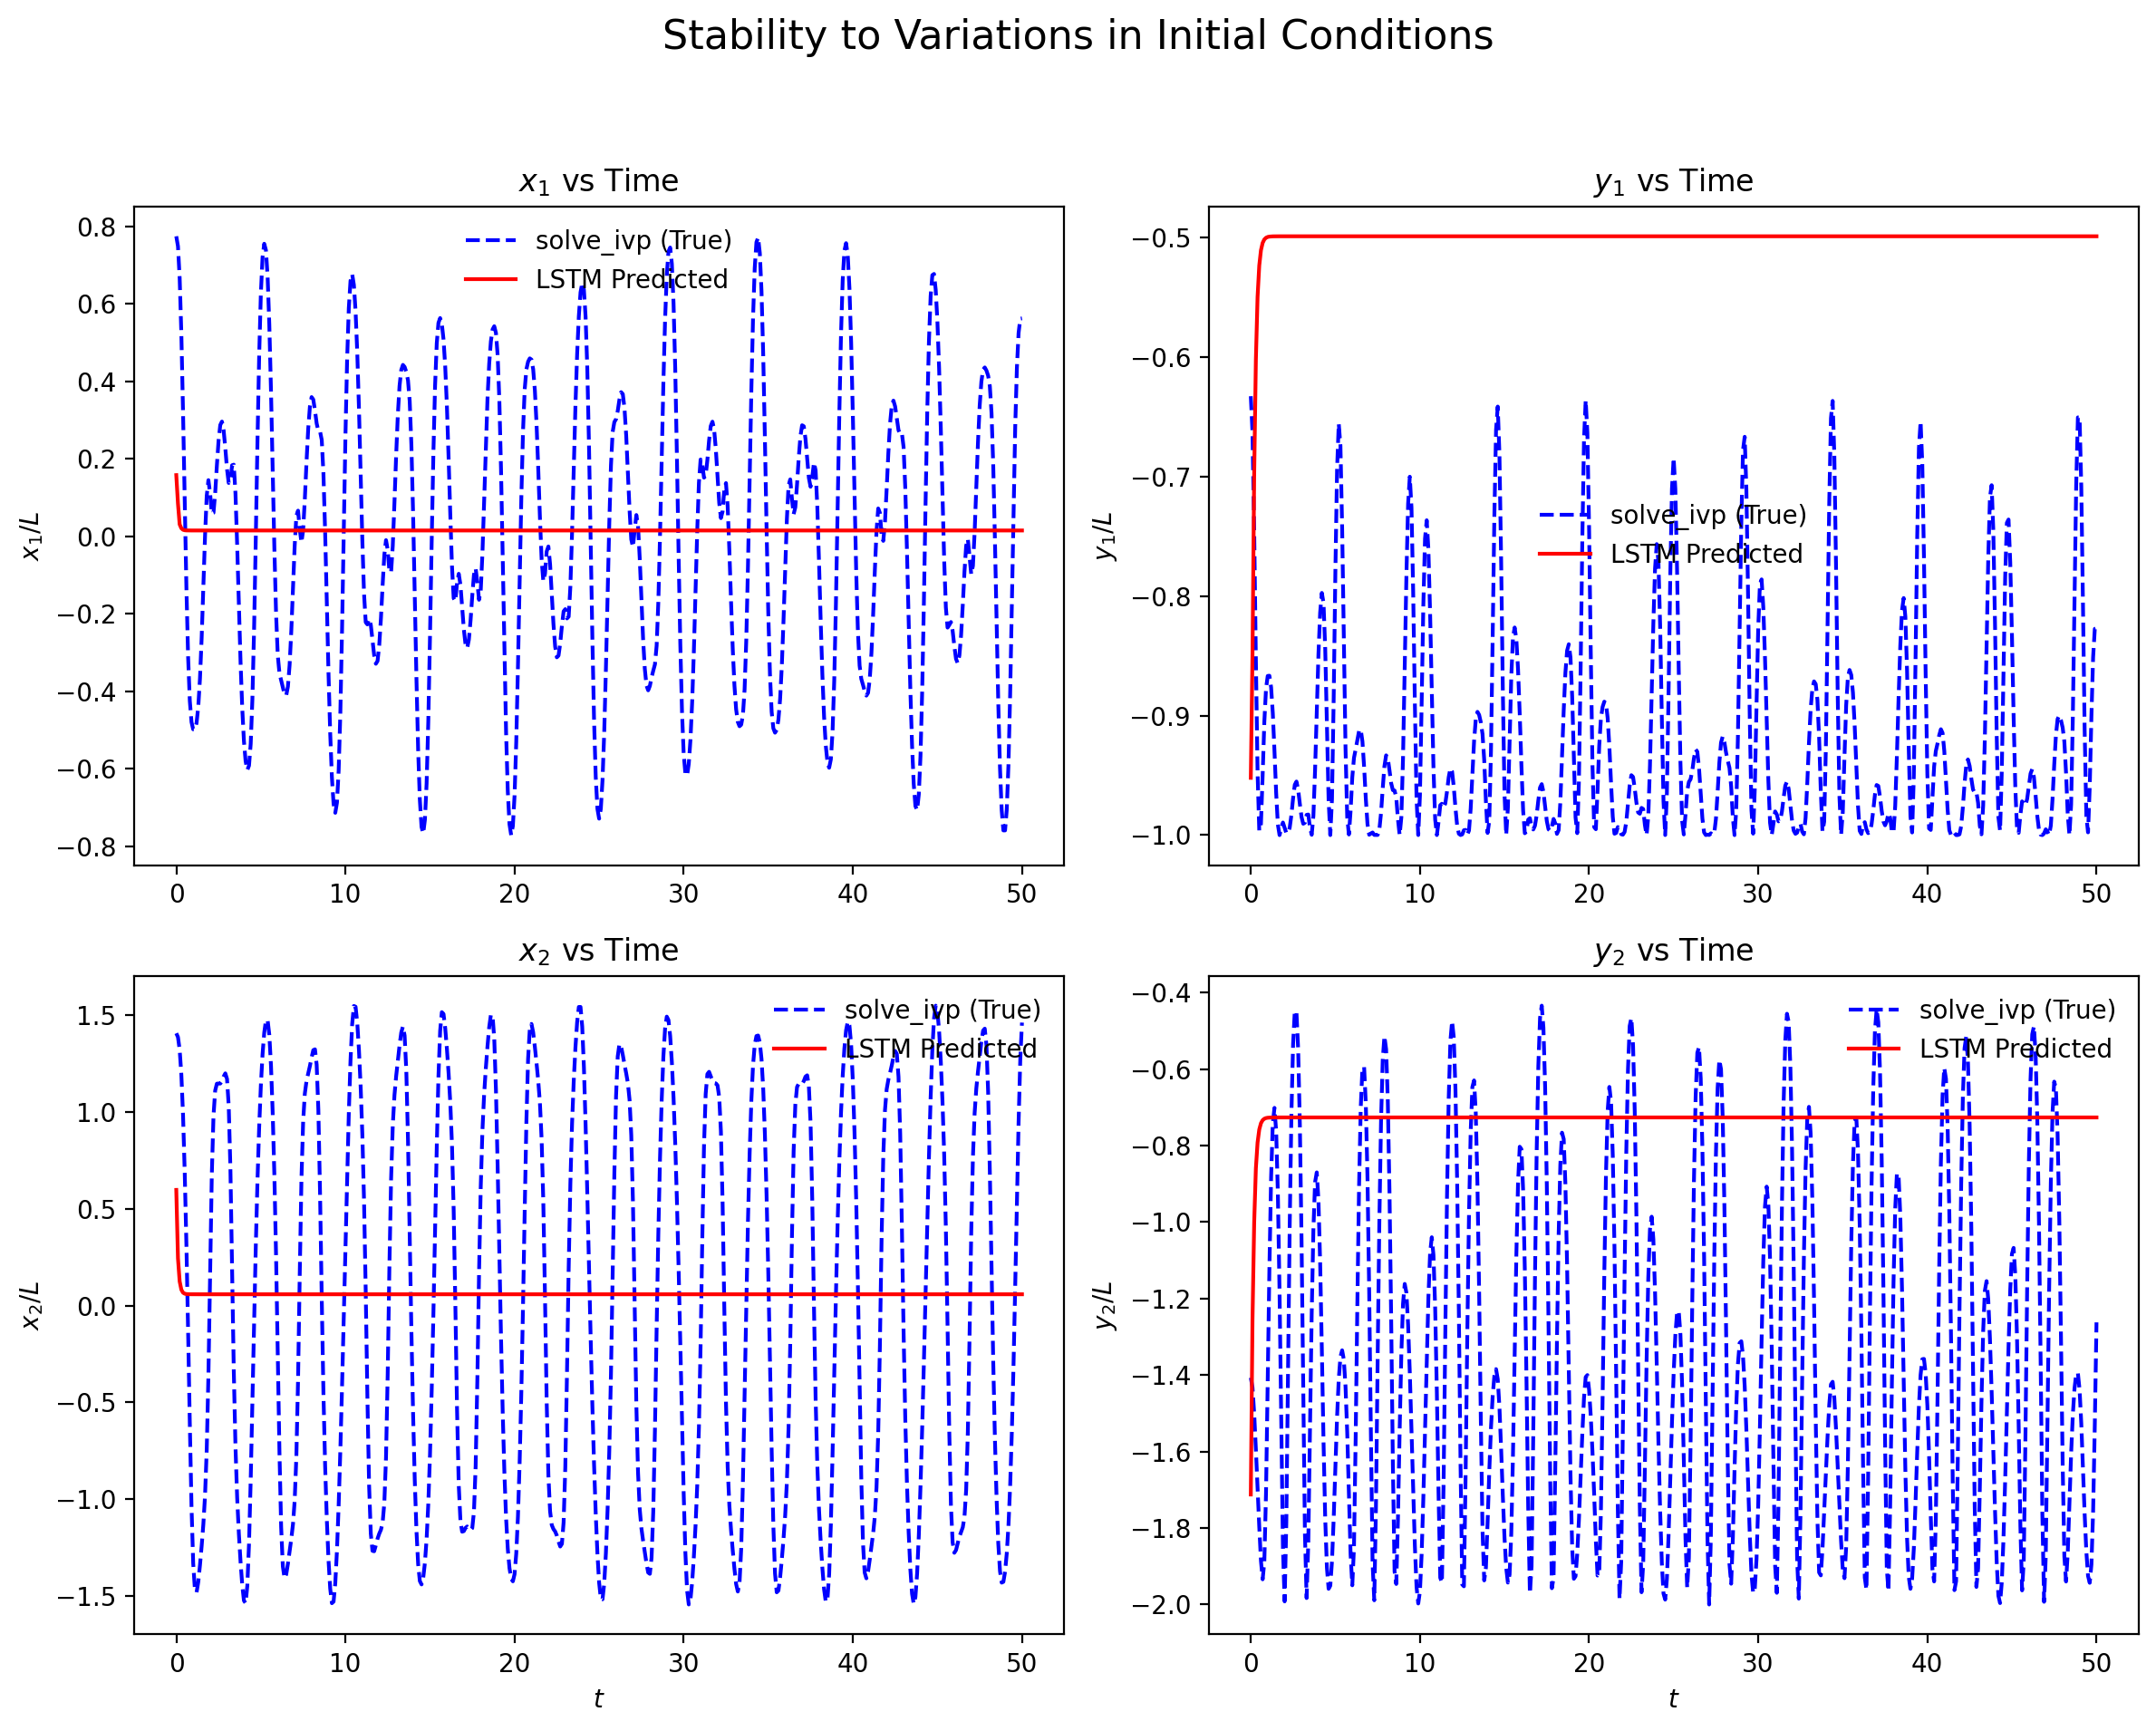

In [103]:
# Perturbed Initial Conditions
z0_perturbed = [np.pi/4 + 0.1, 0, np.pi/4 - 0.1, 0]  # Slightly perturb initial angles

# Solve_ivp solution with perturbed IC (True trajectory)
ret_perturbed = solve_ivp(rhs, (0, tmax), z0_perturbed, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z_perturbed = ret_perturbed.y
theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed = z_perturbed[0], z_perturbed[1], z_perturbed[2], z_perturbed[3]
x1_true_perturbed, y1_true_perturbed, x2_true_perturbed, y2_true_perturbed = to_cartesian(theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed, L1, L2)

# LSTM Prediction with perturbed IC
initial_cartesian_perturbed = to_cartesian(z0_perturbed[0], z0_perturbed[1], z0_perturbed[2], z0_perturbed[3], L1, L2)
initial_input_perturbed = np.array(initial_cartesian_perturbed).reshape((1, 4)) # Initial state for prediction
lstm_input_perturbed = initial_input_perturbed.reshape((1, sequence_length, 4)) # Reshape for LSTM

x1_predicted_perturbed_list = []
y1_predicted_perturbed_list = []
x2_predicted_perturbed_list = []
y2_predicted_perturbed_list = []

current_input = lstm_input_perturbed.copy() # Start prediction from the perturbed initial state

for _ in range(len(t)): # Predict for the entire time range
    predicted_output = model.predict(current_input)
    x1_predicted_perturbed_list.append(predicted_output[0][0])
    y1_predicted_perturbed_list.append(predicted_output[0][1])
    x2_predicted_perturbed_list.append(predicted_output[0][2])
    y2_predicted_perturbed_list.append(predicted_output[0][3])
    current_input = predicted_output.reshape((1, sequence_length, 4)) # Feed predicted output as next input

x1_predicted_perturbed = np.array(x1_predicted_perturbed_list)
y1_predicted_perturbed = np.array(y1_predicted_perturbed_list)
x2_predicted_perturbed = np.array(x2_predicted_perturbed_list)
y2_predicted_perturbed = np.array(y2_predicted_perturbed_list)


# Plotting for Stability Analysis
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Stability to Variations in Initial Conditions', fontsize=16)

axs[0, 0].plot(t, x1_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0, 0].plot(t, x1_predicted_perturbed, label='LSTM Predicted', color='red')
axs[0, 0].set_ylabel(r"$x_1/L$")
axs[0, 0].set_title(r"$x_1$ vs Time")
axs[0, 0].legend()

axs[0, 1].plot(t, y1_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0, 1].plot(t, y1_predicted_perturbed, label='LSTM Predicted', color='red')
axs[0, 1].set_ylabel(r"$y_1/L$")
axs[0, 1].set_title(r"$y_1$ vs Time")
axs[0, 1].legend()

axs[1, 0].plot(t, x2_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1, 0].plot(t, x2_predicted_perturbed, label='LSTM Predicted', color='red')
axs[1, 0].set_ylabel(r"$x_2/L$")
axs[1, 0].set_xlabel(r"$t$")
axs[1, 0].set_title(r"$x_2$ vs Time")
axs[1, 0].legend()

axs[1, 1].plot(t, y2_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1, 1].plot(t, y2_predicted_perturbed, label='LSTM Predicted', color='red')
axs[1, 1].set_ylabel(r"$y_2/L$")
axs[1, 1].set_xlabel(r"$t$")
axs[1, 1].set_title(r"$y_2$ vs Time")
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)


Training for future_step = 20
future_step: 20, RMSE Deviation: 0.8038

Training for future_step = 30
future_step: 30, RMSE Deviation: 0.6145

Training for future_step = 40
future_step: 40, RMSE Deviation: 0.1939

Training for future_step = 50
future_step: 50, RMSE Deviation: 0.3080

Training for future_step = 60
future_step: 60, RMSE Deviation: 0.7998

Training for future_step = 70
future_step: 70, RMSE Deviation: 0.7326

Training for future_step = 80
future_step: 80, RMSE Deviation: 0.4036

Training for future_step = 90
future_step: 90, RMSE Deviation: 0.0620

Training for future_step = 100
future_step: 100, RMSE Deviation: 0.6600


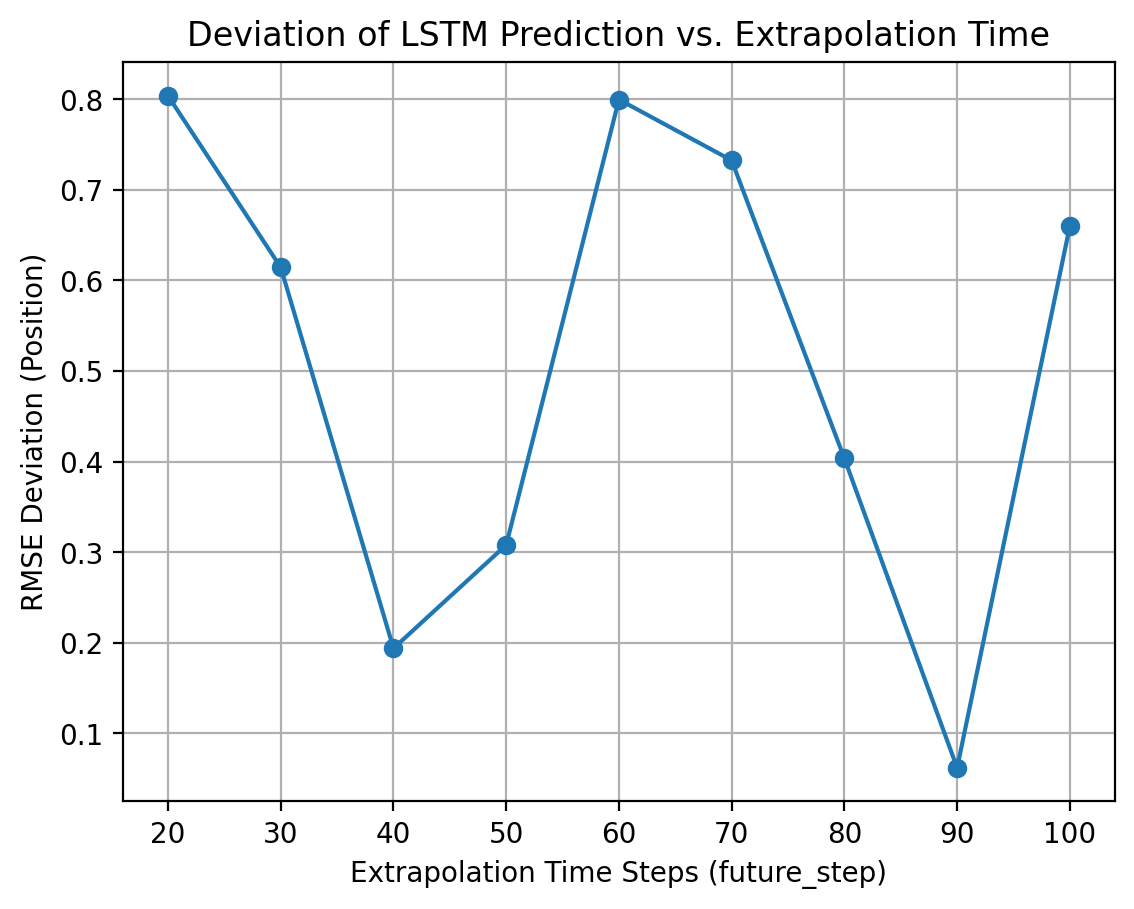

In [104]:
# Generate "future" true data for comparison (longer simulation)
max_future_step = 100 # Maximum extrapolation time considered
tmax_long = tmax + max_future_step * dt
t_long = np.arange(0, tmax_long + dt, dt)
ret_long = solve_ivp(rhs, (0, tmax_long), z0, t_eval=t_long, args=(L1, L2, m1, m2, g), method='RK45')
z_long = ret_long.y
theta1_long, w1_long, theta2_long, w2_long = z_long[0], z_long[1], z_long[2], z_long[3]
x1_data_long, y1_data_long, x2_data_long, y2_data_long = to_cartesian(theta1_long, w1_long, theta2_long, w2_long, L1, L2)
cartesian_data_long = np.stack([x1_data_long, y1_data_long, x2_data_long, y2_data_long], axis=1)

future_step_values = range(20, 101, 10) # Extrapolation times to test
deviation_rmse_values = []

for future_step in future_step_values:
    print(f"\nTraining for future_step = {future_step}")

    # Prepare training data for current future_step
    X_train = []
    y_train = []
    for i in range(0, len(cartesian_data) - sequence_length - future_step):
        X_train.append(cartesian_data[i:i+sequence_length])
        y_train.append(cartesian_data[i+sequence_length+future_step])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 4))

    # Build and train LSTM model (new model for each future_step)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Train silently

    # Make prediction for future position (extrapolation)
    last_input = cartesian_data[-sequence_length:].reshape((1, sequence_length, 4))
    predicted_future_position = model.predict(last_input, verbose=0)

    # Get actual position from the longer simulation
    actual_future_position = cartesian_data_long[len(cartesian_data) + future_step -1] # Indexing into cartesian_data_long

    # Calculate RMSE deviation
    rmse = np.sqrt(mean_squared_error(actual_future_position, predicted_future_position[0]))
    deviation_rmse_values.append(rmse)
    print(f"future_step: {future_step}, RMSE Deviation: {rmse:.4f}")


# Plotting deviation vs extrapolation time
plt.figure()
plt.plot(future_step_values, deviation_rmse_values, marker='o')
plt.title('Deviation of LSTM Prediction vs. Extrapolation Time')
plt.xlabel('Extrapolation Time Steps (future_step)')
plt.ylabel('RMSE Deviation (Position)')
plt.xticks(future_step_values)
plt.grid(True)
plt.show()

4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

Predicted future position (x1, y1, x2, y2) at t = t0 + 20*dt: [[-0.4384001  -0.52137244 -0.4078971  -0.65513825]]


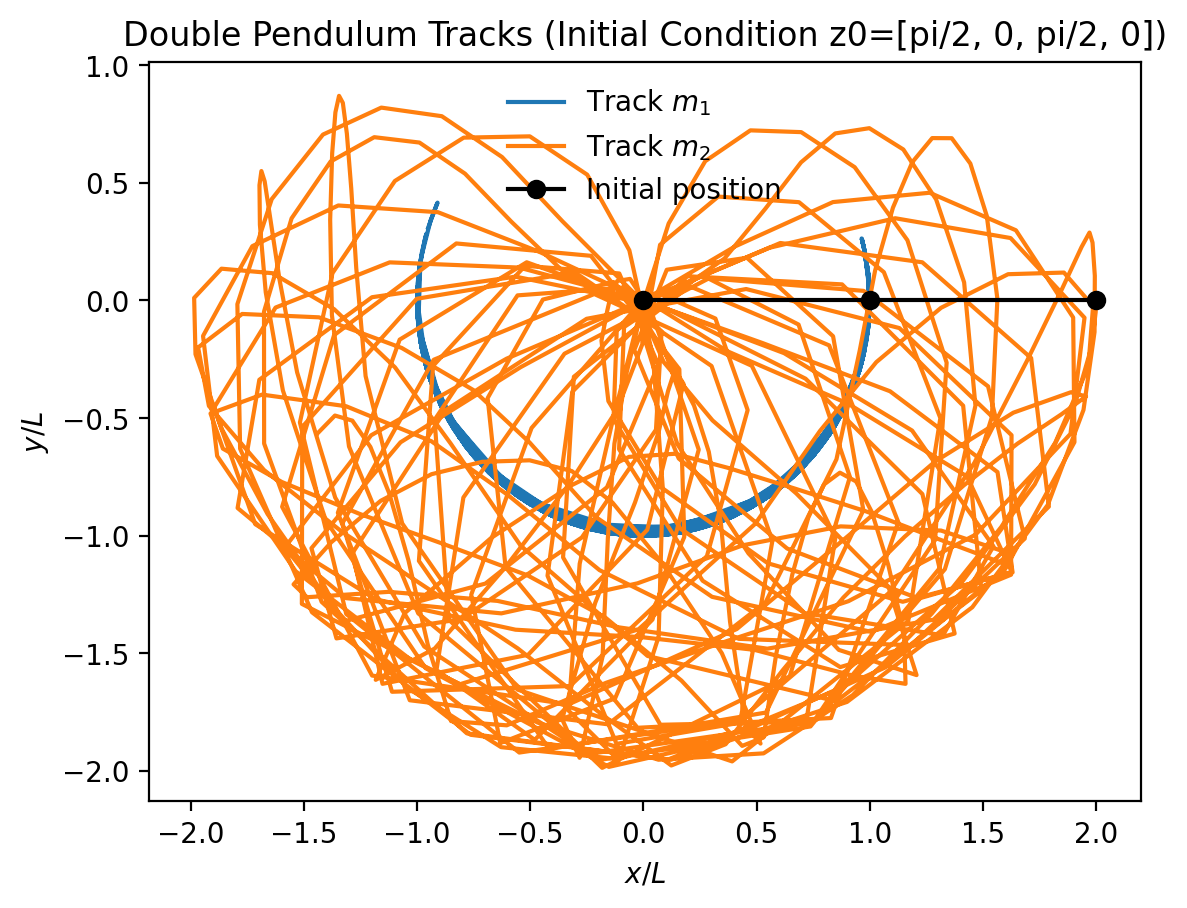

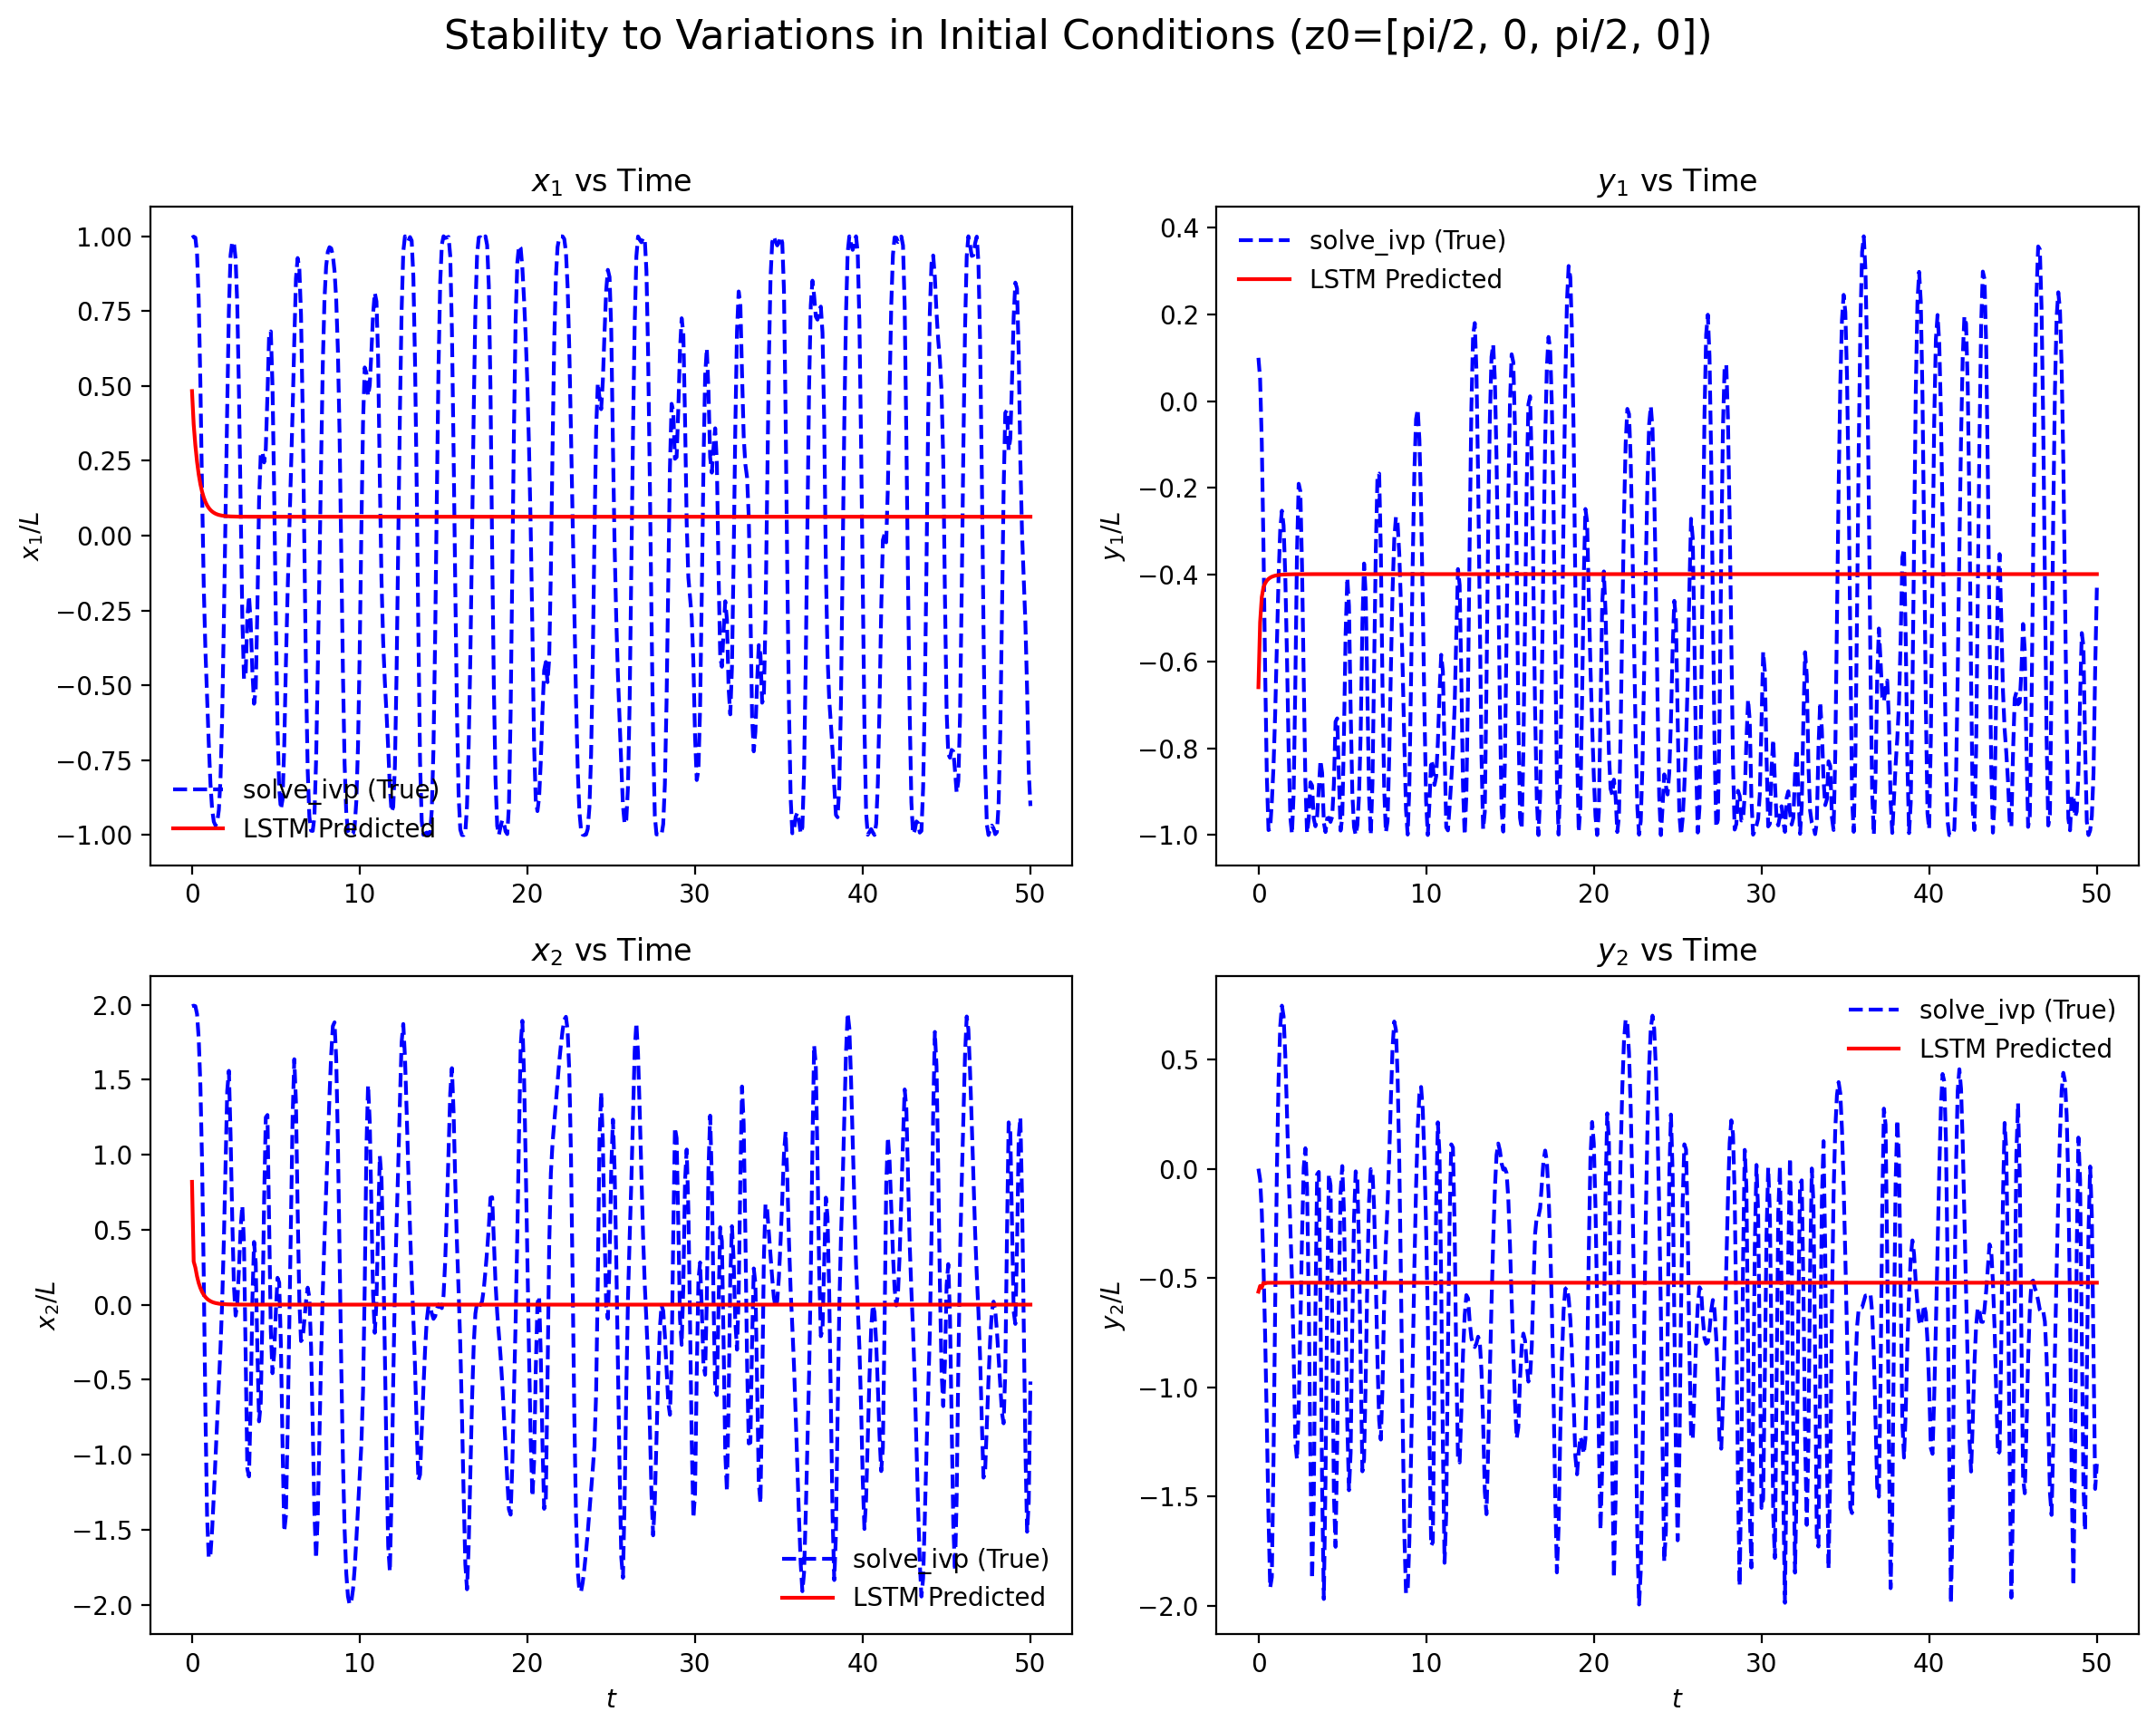


Training for future_step = 20
future_step: 20, RMSE Deviation: 0.4732

Training for future_step = 30
future_step: 30, RMSE Deviation: 0.7385

Training for future_step = 40
future_step: 40, RMSE Deviation: 1.0370

Training for future_step = 50
future_step: 50, RMSE Deviation: 0.4734

Training for future_step = 60
future_step: 60, RMSE Deviation: 1.0852

Training for future_step = 70
future_step: 70, RMSE Deviation: 1.0745

Training for future_step = 80
future_step: 80, RMSE Deviation: 0.4516

Training for future_step = 90
future_step: 90, RMSE Deviation: 0.3844

Training for future_step = 100
future_step: 100, RMSE Deviation: 0.4468


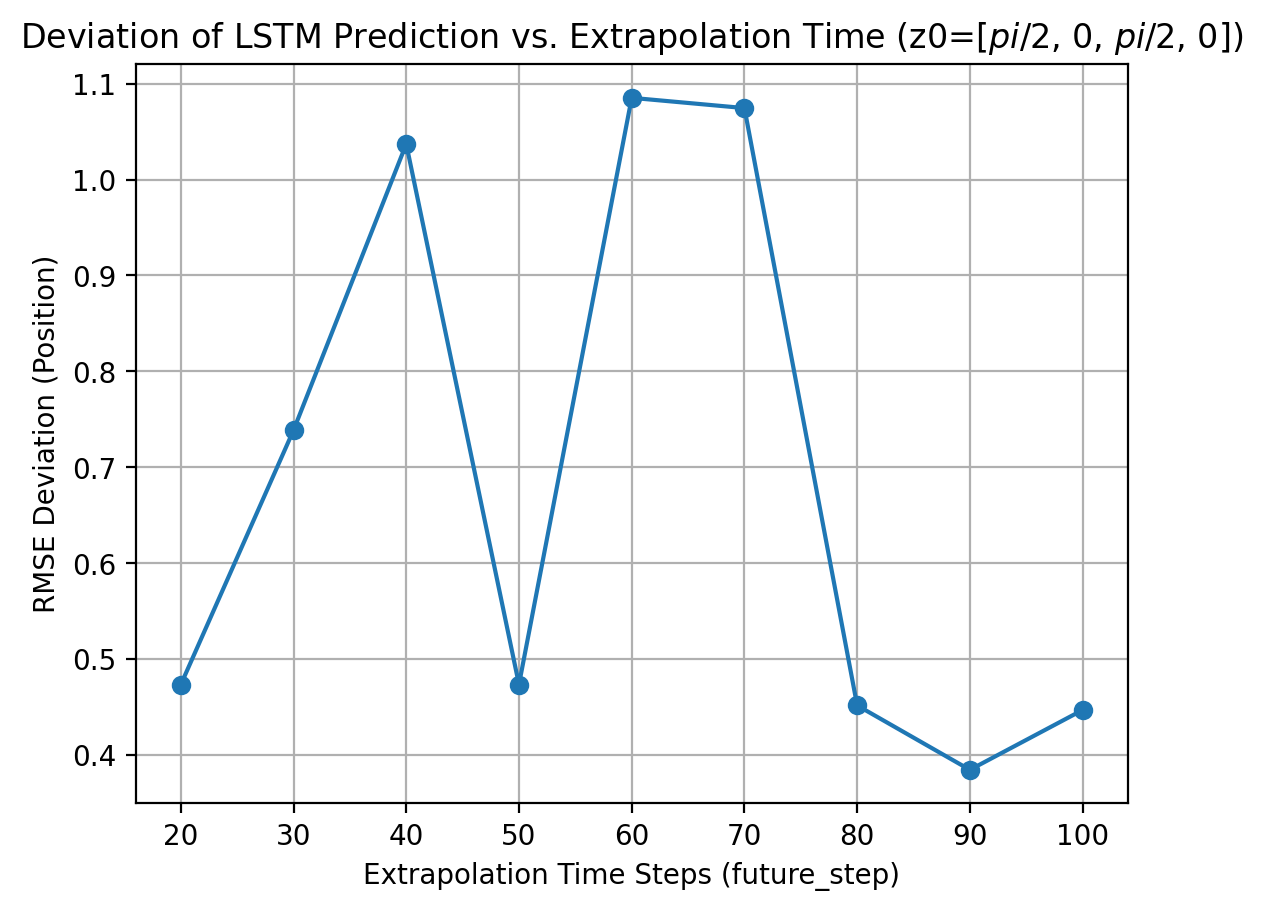

In [105]:
# Parameters setup
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81
z0 = [np.pi/2, 0, np.pi/2, 0] # New initial condition
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)
sequence_length = 1

# Question 1: Design and train RNN

# Generate training data
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z=ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1_data, y1_data, x2_data, y2_data = to_cartesian(theta1, w1, theta2, w2, L1, L2)
cartesian_data = np.stack([x1_data, y1_data, x2_data, y2_data], axis=1)

# Prepare data for LSTM
future_step = 20 # Fixed future step for training
X_train = []
y_train = []
for i in range(0, len(cartesian_data) - sequence_length - future_step):
    X_train.append(cartesian_data[i:i+sequence_length])
    y_train.append(cartesian_data[i+sequence_length+future_step])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 4))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
model.add(Dense(4))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make a prediction
last_input = cartesian_data[-sequence_length:].reshape((1, sequence_length, 4))
predicted_future_position = model.predict(last_input, verbose=0)

print("Predicted future position (x1, y1, x2, y2) at t = t0 + 20*dt:", predicted_future_position)

# Plotting
fig,ax=plt.subplots()
ax.plot(x1_data, y1_data, label=r"Track $m_1$")
ax.plot(x2_data, y2_data, label=r"Track $m_2$")
ax.plot([0, x1_data[0], x2_data[0]], [0, y1_data[0], y2_data[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()
plt.title('Double Pendulum Tracks (Initial Condition z0=[pi/2, 0, pi/2, 0])')
plt.show()


# Question 2: Stability to variations in initial conditions

# Perturbed Initial Conditions
z0_perturbed = [np.pi/2 + 0.1, 0, np.pi/2 - 0.1, 0]  # Slightly perturb initial angles

# Solve_ivp solution with perturbed IC (True trajectory)
ret_perturbed = solve_ivp(rhs, (0, tmax), z0_perturbed, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z_perturbed = ret_perturbed.y
theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed = z_perturbed[0], z_perturbed[1], z_perturbed[2], z_perturbed[3]
x1_true_perturbed, y1_true_perturbed, x2_true_perturbed, y2_true_perturbed = to_cartesian(theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed, L1, L2)

# LSTM Prediction with perturbed IC
initial_cartesian_perturbed = to_cartesian(z0_perturbed[0], z0_perturbed[1], z0_perturbed[2], z0_perturbed[3], L1, L2)
initial_input_perturbed = np.array([initial_cartesian_perturbed]).reshape((1, 4))
lstm_input_perturbed = initial_input_perturbed.reshape((1, sequence_length, 4))

x1_predicted_perturbed_list = []
y1_predicted_perturbed_list = []
x2_predicted_perturbed_list = []
y2_predicted_perturbed_list = []

current_input = lstm_input_perturbed.copy()

for _ in range(len(t)):
    predicted_output = model.predict(current_input, verbose=0)
    x1_predicted_perturbed_list.append(predicted_output[0][0])
    y1_predicted_perturbed_list.append(predicted_output[0][1])
    x2_predicted_perturbed_list.append(predicted_output[0][2])
    y2_predicted_perturbed_list.append(predicted_output[0][3])
    current_input = predicted_output.reshape((1, sequence_length, 4))

x1_predicted_perturbed = np.array(x1_predicted_perturbed_list)
y1_predicted_perturbed = np.array(y1_predicted_perturbed_list)
x2_predicted_perturbed = np.array(x2_predicted_perturbed_list)
y2_predicted_perturbed = np.array(y2_predicted_perturbed_list)


# Plotting for Stability Analysis
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Stability to Variations in Initial Conditions (z0=[pi/2, 0, pi/2, 0])', fontsize=16)

axs[0, 0].plot(t, x1_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0, 0].plot(t, x1_predicted_perturbed, label='LSTM Predicted', color='red')
axs[0, 0].set_ylabel(r"$x_1/L$")
axs[0, 0].set_title(r"$x_1$ vs Time")
axs[0, 0].legend()

axs[0, 1].plot(t, y1_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0, 1].plot(t, y1_predicted_perturbed, label='LSTM Predicted', color='red')
axs[0, 1].set_ylabel(r"$y_1/L$")
axs[0, 1].set_title(r"$y_1$ vs Time")
axs[0, 1].legend()

axs[1, 0].plot(t, x2_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1, 0].plot(t, x2_predicted_perturbed, label='LSTM Predicted', color='red')
axs[1, 0].set_ylabel(r"$x_2/L$")
axs[1, 0].set_xlabel(r"$t$")
axs[1, 0].set_title(r"$x_2$ vs Time")
axs[1, 0].legend()

axs[1, 1].plot(t, y2_true_perturbed, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1, 1].plot(t, y2_predicted_perturbed, label='LSTM Predicted', color='red')
axs[1, 1].set_ylabel(r"$y_2/L$")
axs[1, 1].set_xlabel(r"$t$")
axs[1, 1].set_title(r"$y_2$ vs Time")
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Question 3: How far into the future can the network predict?

# Generate "future" true data for comparison (longer simulation)
max_future_step = 100 # Maximum extrapolation time considered
tmax_long = tmax + max_future_step * dt
t_long = np.arange(0, tmax_long + dt, dt)
ret_long = solve_ivp(rhs, (0, tmax_long), z0, t_eval=t_long, args=(L1, L2, m1, m2, g), method='RK45')
z_long = ret_long.y
theta1_long, w1_long, theta2_long, w2_long = z_long[0], z_long[1], z_long[2], z_long[3]
x1_data_long, y1_data_long, x2_data_long, y2_data_long = to_cartesian(theta1_long, w1_long, theta2_long, w2_long, L1, L2)
cartesian_data_long = np.stack([x1_data_long, y1_data_long, x2_data_long, y2_data_long], axis=1)


future_step_values = range(20, 101, 10) # Extrapolation times to test
deviation_rmse_values = []

for future_step in future_step_values:
    print(f"\nTraining for future_step = {future_step}")

    # Prepare training data for current future_step
    X_train = []
    y_train = []
    for i in range(0, len(cartesian_data) - sequence_length - future_step):
        X_train.append(cartesian_data[i:i+sequence_length])
        y_train.append(cartesian_data[i+sequence_length+future_step])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 4))

    # Build and train LSTM model (new model for each future_step)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Train silently

    # Make prediction for future position (extrapolation)
    last_input = cartesian_data[-sequence_length:].reshape((1, sequence_length, 4))
    predicted_future_position = model.predict(last_input, verbose=0)

    # Get actual position from the longer simulation
    actual_future_position = cartesian_data_long[len(cartesian_data) + future_step -1] # Indexing into cartesian_data_long

    # Calculate RMSE deviation
    rmse = np.sqrt(mean_squared_error(actual_future_position, predicted_future_position[0]))
    deviation_rmse_values.append(rmse)
    print(f"future_step: {future_step}, RMSE Deviation: {rmse:.4f}")


# Plotting deviation vs extrapolation time
plt.figure()
plt.plot(future_step_values, deviation_rmse_values, marker='o')
plt.title('Deviation of LSTM Prediction vs. Extrapolation Time (z0=[$pi/2$, 0, $pi/2$, 0])')
plt.xlabel('Extrapolation Time Steps (future_step)')
plt.ylabel('RMSE Deviation (Position)')
plt.xticks(future_step_values)
plt.grid(True)
plt.show()

5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

Predicted future position (x2, y2) at t = t0 + 20*dt (m2-only training): [[-0.35691956 -1.509876  ]]


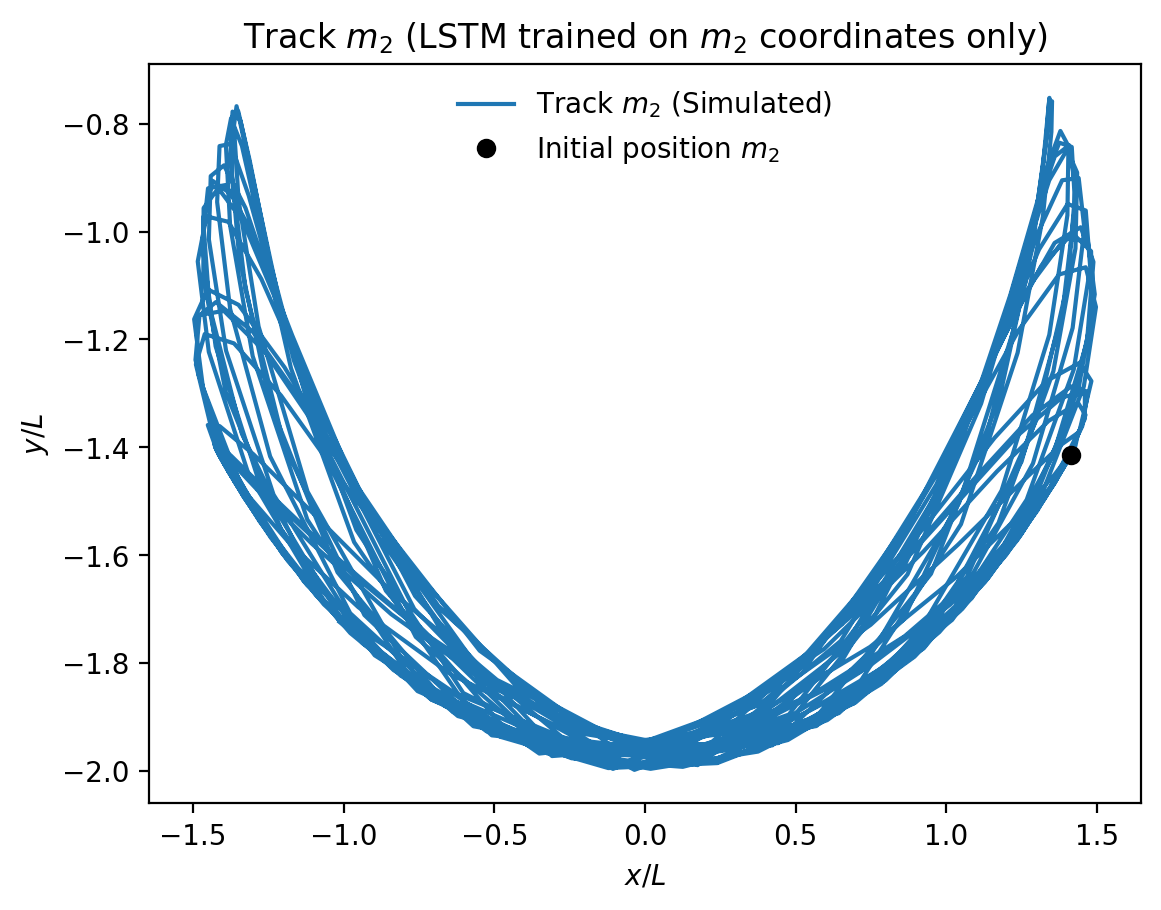

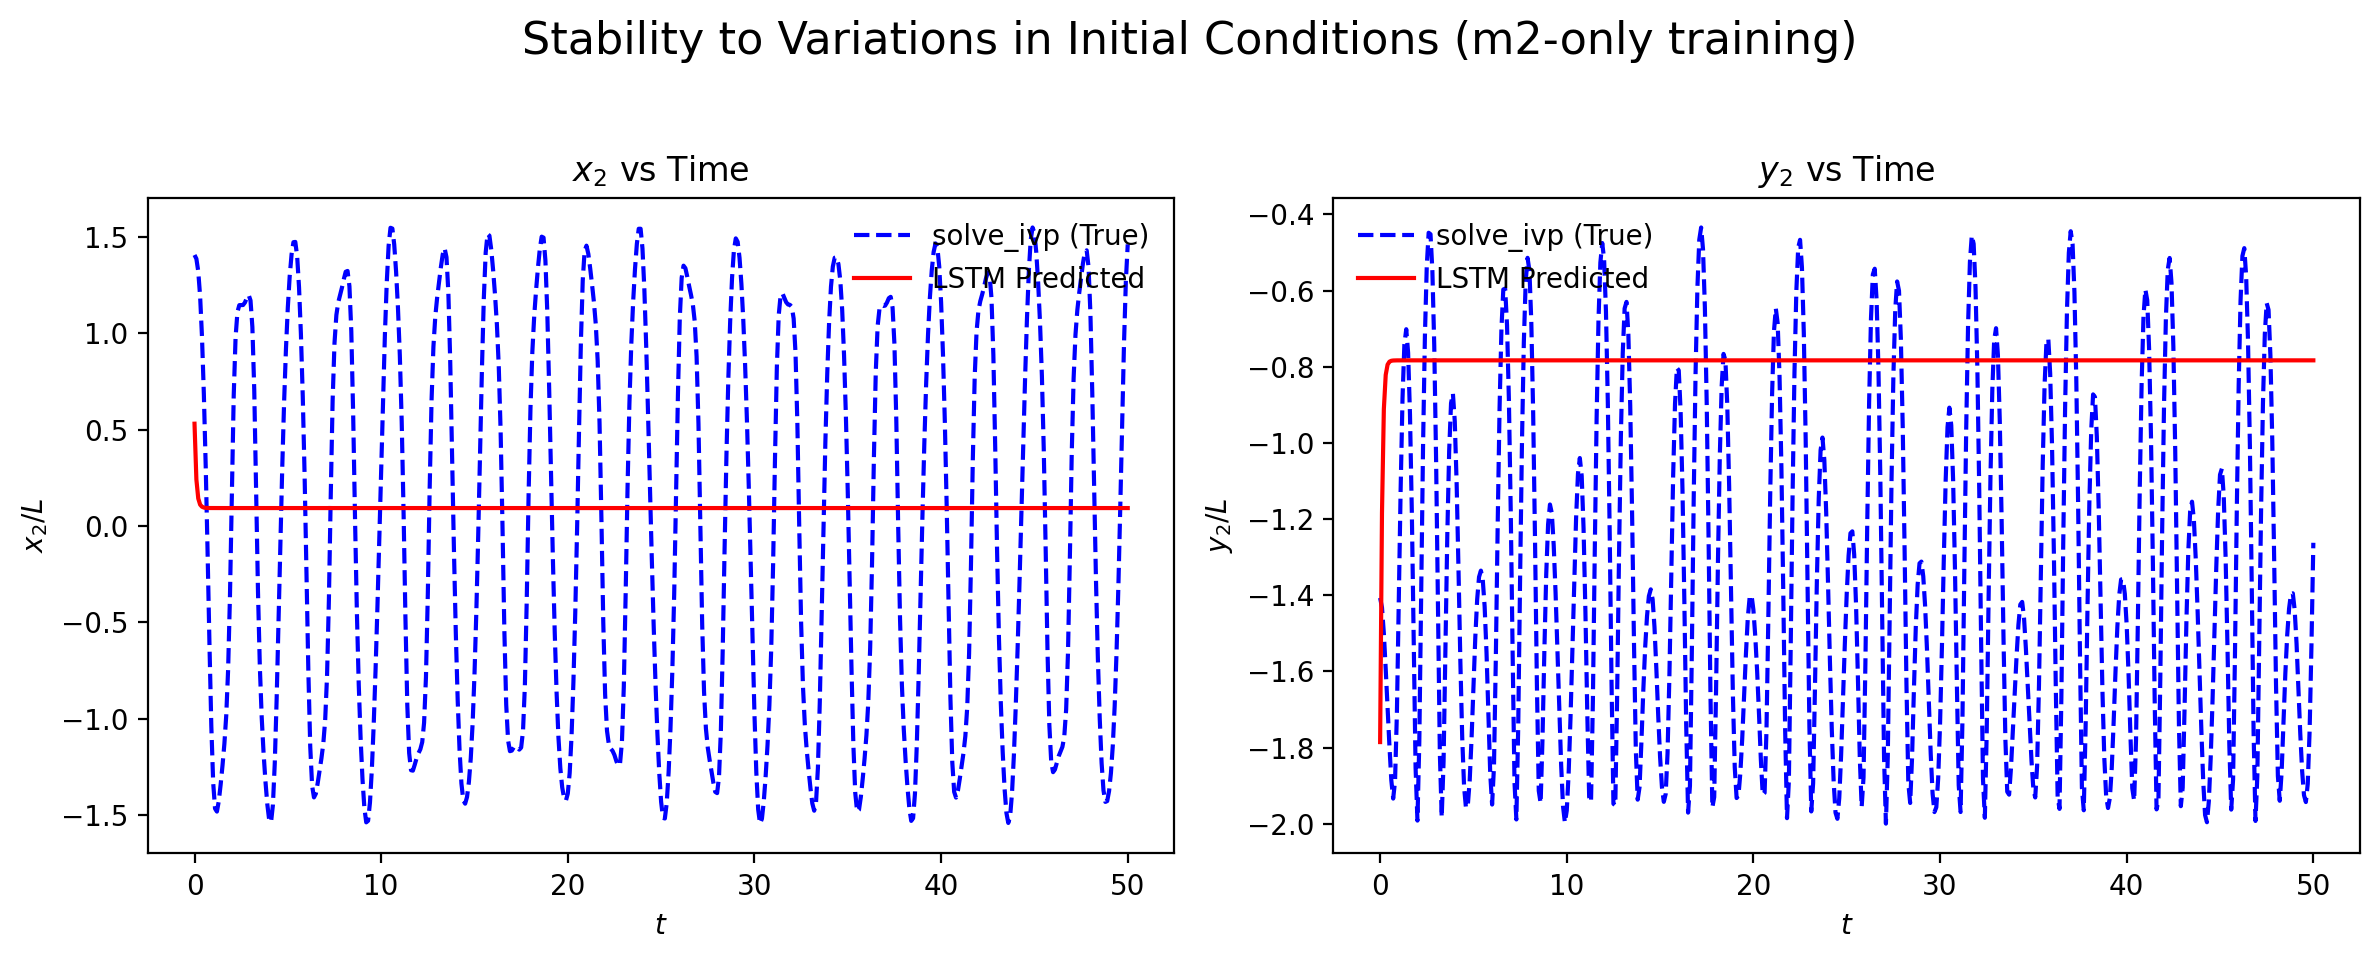


--- Training for future_step = 20 (m2-only) ---
future_step: 20, RMSE Deviation (m2-only): 1.1070

--- Training for future_step = 30 (m2-only) ---
future_step: 30, RMSE Deviation (m2-only): 0.8265

--- Training for future_step = 40 (m2-only) ---
future_step: 40, RMSE Deviation (m2-only): 0.2662

--- Training for future_step = 50 (m2-only) ---
future_step: 50, RMSE Deviation (m2-only): 0.3736

--- Training for future_step = 60 (m2-only) ---
future_step: 60, RMSE Deviation (m2-only): 1.0785

--- Training for future_step = 70 (m2-only) ---
future_step: 70, RMSE Deviation (m2-only): 0.9582

--- Training for future_step = 80 (m2-only) ---
future_step: 80, RMSE Deviation (m2-only): 0.4836

--- Training for future_step = 90 (m2-only) ---
future_step: 90, RMSE Deviation (m2-only): 0.0548

--- Training for future_step = 100 (m2-only) ---
future_step: 100, RMSE Deviation (m2-only): 0.8402


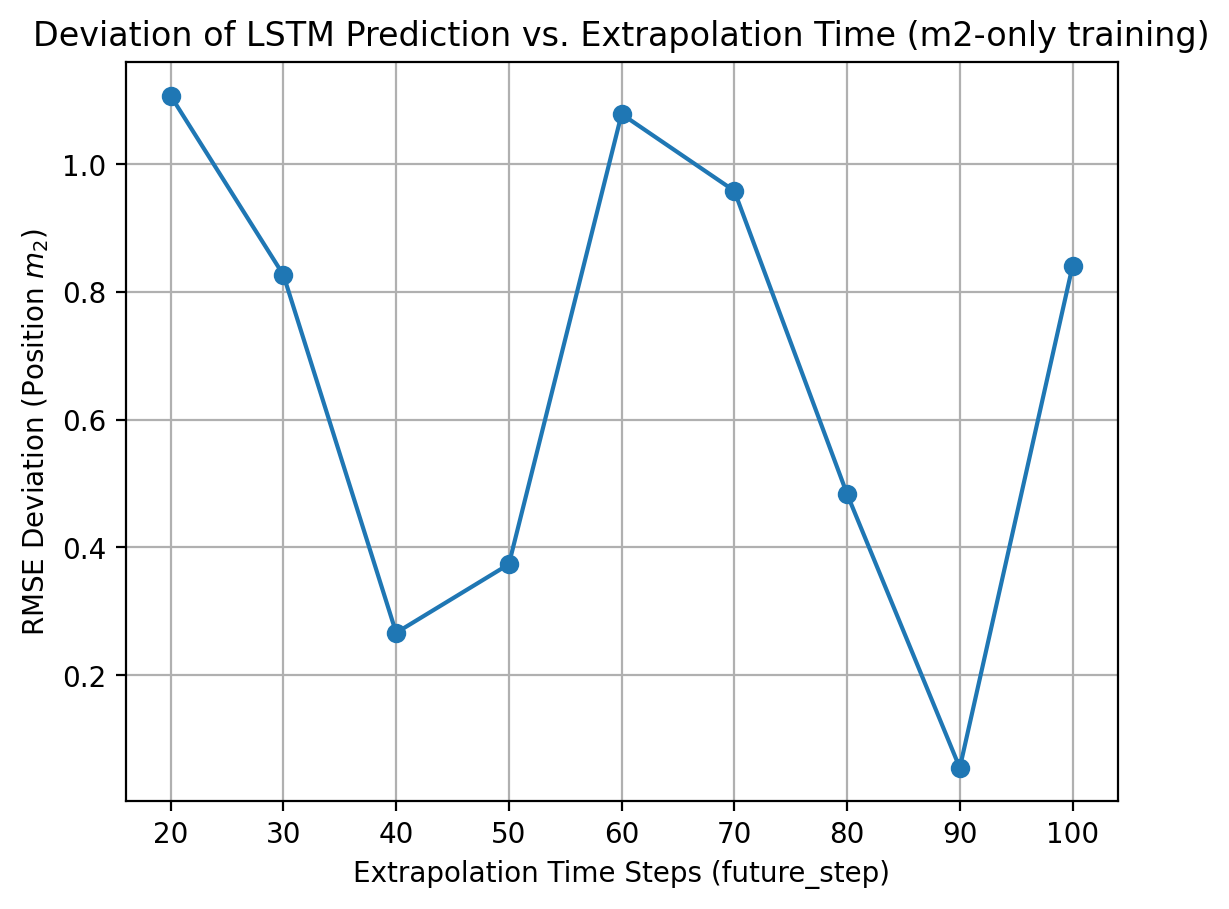

In [ ]:
# Parameters setup
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81
z0 = [np.pi/4, 0, np.pi/4, 0]
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)
sequence_length = 1

# Question 1: Design and train RNN

# Generate training data (using both masses for simulation, but only m2 for training)
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z=ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1_data, y1_data, x2_data, y2_data = to_cartesian(theta1, w1, theta2, w2, L1, L2)
cartesian_data_full = np.stack([x1_data, y1_data, x2_data, y2_data], axis=1) # Keep full data for plotting/comparison
cartesian_data_m2_only = np.stack([x2_data, y2_data], axis=1) # Training data: only m2 coordinates

# Prepare data for LSTM - using only m2 coordinates
future_step = 20 # Fixed future step for training in Question 5
input_features = 2 # Only x2, y2 for input
output_features = 2 # Only predict x2, y2
X_train = []
y_train = []
for i in range(0, len(cartesian_data_m2_only) - sequence_length - future_step):
    X_train.append(cartesian_data_m2_only[i:i+sequence_length])
    y_train.append(cartesian_data_m2_only[i+sequence_length+future_step])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, input_features))

# Build LSTM model - input and output dimensions adjusted for m2 only
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, input_features)))
model.add(Dense(output_features)) # Output layer with 2 units (x2, y2)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make a prediction - using only m2 initial condition
last_input_m2_only = cartesian_data_m2_only[-sequence_length:].reshape((1, sequence_length, input_features))
predicted_future_position_m2_only = model.predict(last_input_m2_only, verbose=0)

print("Predicted future position (x2, y2) at t = t0 + 20*dt (m2-only training):", predicted_future_position_m2_only)

# Plotting
fig,ax=plt.subplots()
ax.plot(x2_data, y2_data, label=r"Track $m_2$ (Simulated)") # Plot only m2 track
ax.plot([x2_data[0]], [y2_data[0]], "o", label="Initial position $m_2$", c='k') # Initial position of m2
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()
plt.title('Track $m_2$ (LSTM trained on $m_2$ coordinates only)')
plt.show()


# Question 2: Stability to variations in initial conditions (m2-only training)

# Perturbed Initial Conditions
z0_perturbed = [np.pi/4 + 0.1, 0, np.pi/4 - 0.1, 0]  # Slightly perturb initial angles

# Solve_ivp solution with perturbed IC (True trajectory - for m2 only)
ret_perturbed = solve_ivp(rhs, (0, tmax), z0_perturbed, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z_perturbed = ret_perturbed.y
theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed = z_perturbed[0], z_perturbed[1], z_perturbed[2], z_perturbed[3]
x1_true_perturbed, y1_true_perturbed, x2_true_perturbed, y2_true_perturbed = to_cartesian(theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed, L1, L2)
x2_true_perturbed_m2_only = x2_true_perturbed
y2_true_perturbed_m2_only = y2_true_perturbed # True m2 trajectory for perturbed IC

# LSTM Prediction with perturbed IC (m2-only training)
initial_cartesian_perturbed = to_cartesian(z0_perturbed[0], z0_perturbed[1], z0_perturbed[2], z0_perturbed[3], L1, L2)
initial_cartesian_perturbed_m2_only = (initial_cartesian_perturbed[2], initial_cartesian_perturbed[3]) # Only m2 coords
initial_input_perturbed_m2_only = np.array([initial_cartesian_perturbed_m2_only]).reshape((1, output_features)) # Use output_features which is 2
lstm_input_perturbed_m2_only = initial_input_perturbed_m2_only.reshape((1, sequence_length, input_features)) # Use input_features which is 2

x2_predicted_perturbed_list_m2_only = []
y2_predicted_perturbed_list_m2_only = []


current_input_m2_only = lstm_input_perturbed_m2_only.copy()

for _ in range(len(t)):
    predicted_output_m2_only = model.predict(current_input_m2_only, verbose=0)
    x2_predicted_perturbed_list_m2_only.append(predicted_output_m2_only[0][0])
    y2_predicted_perturbed_list_m2_only.append(predicted_output_m2_only[0][1])
    current_input_m2_only = predicted_output_m2_only.reshape((1, sequence_length, input_features))

x2_predicted_perturbed_m2_only = np.array(x2_predicted_perturbed_list_m2_only)
y2_predicted_perturbed_m2_only = np.array(y2_predicted_perturbed_list_m2_only)


# Plotting for Stability Analysis (m2-only)
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) # Reduced to 1x2 subplots
fig.suptitle('Stability to Variations in Initial Conditions (m2-only training)', fontsize=16)

axs[0].plot(t, x2_true_perturbed_m2_only, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0].plot(t, x2_predicted_perturbed_m2_only, label='LSTM Predicted', color='red')
axs[0].set_ylabel(r"$x_2/L$")
axs[0].set_xlabel(r"$t$")
axs[0].set_title(r"$x_2$ vs Time")
axs[0].legend()

axs[1].plot(t, y2_true_perturbed_m2_only, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1].plot(t, y2_predicted_perturbed_m2_only, label='LSTM Predicted', color='red')
axs[1].set_ylabel(r"$y_2/L$")
axs[1].set_xlabel(r"$t$")
axs[1].set_title(r"$y_2$ vs Time")
axs[1].legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Question 3: How far into the future can the network predict? (m2-only)

# Generate "future" true data for comparison (longer simulation)
max_future_step = 100 # Maximum extrapolation time considered
tmax_long = tmax + max_future_step * dt
t_long = np.arange(0, tmax_long + dt, dt)
ret_long = solve_ivp(rhs, (0, tmax_long), z0, t_eval=t_long, args=(L1, L2, m1, m2, g), method='RK45')
z_long = ret_long.y
theta1_long, w1_long, theta2_long, w2_long = z_long[0], z_long[1], z_long[2], z_long[3]
x1_data_long, y1_data_long, x2_data_long, y2_data_long = to_cartesian(theta1_long, w1_long, theta2_long, w2_long, L1, L2)
cartesian_data_long_m2_only = np.stack([x2_data_long, y2_data_long], axis=1) # Long true data for m2 only


future_step_values = range(20, 101, 10) # Extrapolation times to test
deviation_rmse_values_m2_only = []

for future_step in future_step_values:
    print(f"\n--- Training for future_step = {future_step} (m2-only) ---")

    # Prepare training data for current future_step (m2-only)
    X_train = []
    y_train = []
    for i in range(0, len(cartesian_data_m2_only) - sequence_length - future_step):
        X_train.append(cartesian_data_m2_only[i:i+sequence_length])
        y_train.append(cartesian_data_m2_only[i+sequence_length+future_step])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, input_features)) # Use input_features=2

    # Build and train LSTM model (new model for each future_step, m2-only)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, input_features))) # Use input_features=2
    model.add(Dense(output_features)) # Use output_features=2
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Train silently

    # Make prediction for future position (extrapolation) - m2-only input
    last_input_m2_only = cartesian_data_m2_only[-sequence_length:].reshape((1, sequence_length, input_features)) # Use input_features=2
    predicted_future_position_m2_only = model.predict(last_input_m2_only, verbose=0)

    # Get actual position from the longer simulation (m2-only true data)
    actual_future_position_m2_only = cartesian_data_long_m2_only[len(cartesian_data_m2_only) + future_step -1] # Index into long m2-only data

    # Calculate RMSE deviation (m2-only)
    rmse = np.sqrt(mean_squared_error(actual_future_position_m2_only, predicted_future_position_m2_only[0]))
    deviation_rmse_values_m2_only.append(rmse)
    print(f"future_step: {future_step}, RMSE Deviation (m2-only): {rmse:.4f}")


# Plotting deviation vs extrapolation time (m2-only)
plt.figure()
plt.plot(future_step_values, deviation_rmse_values_m2_only, marker='o')
plt.title('Deviation of LSTM Prediction vs. Extrapolation Time (m2-only training)')
plt.xlabel('Extrapolation Time Steps (future_step)')
plt.ylabel('RMSE Deviation (Position $m_2$)')
plt.xticks(future_step_values)
plt.grid(True)
plt.show()

Predicted future position (x2, y2) at t = t0 + 20*dt (m2-only training): (z0=[$pi/2$, 0, $pi/2$, 0]) [[-0.39559245 -0.7704582 ]]


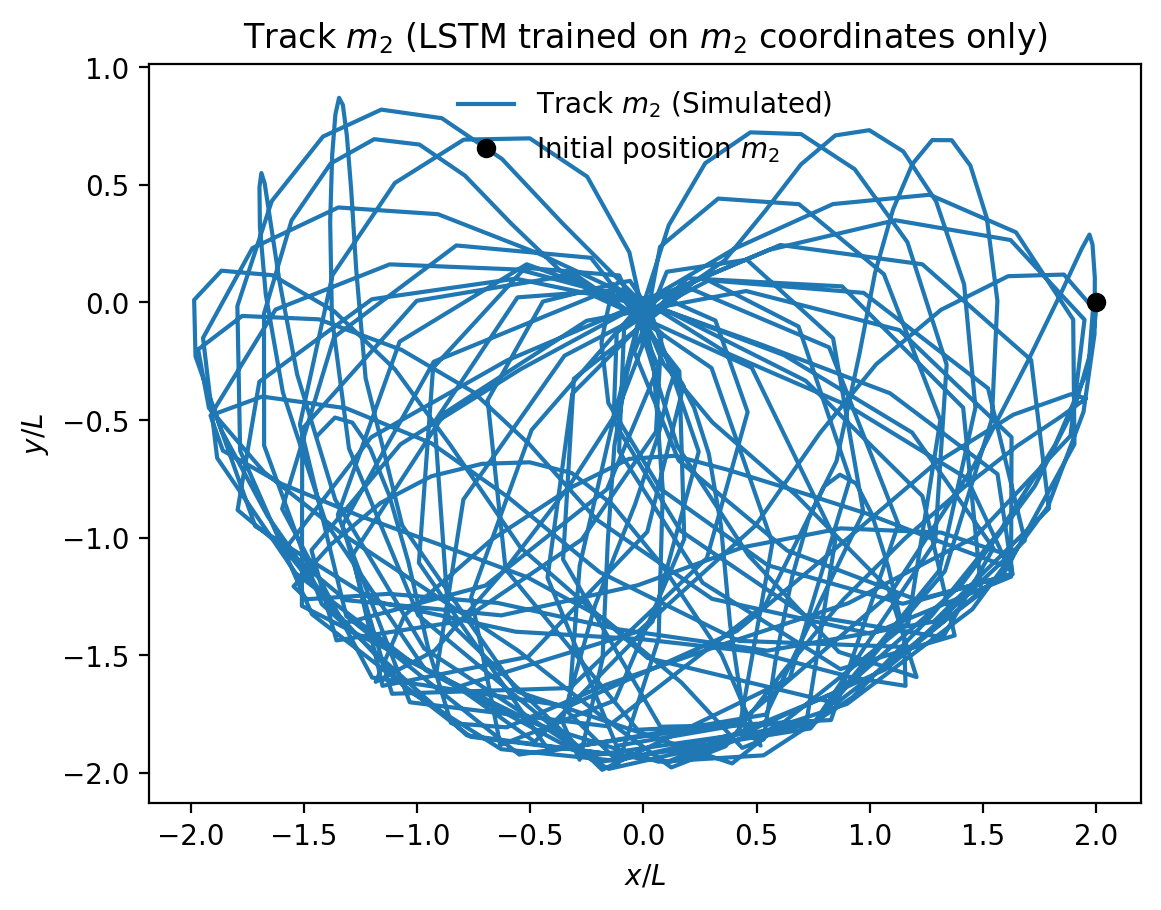

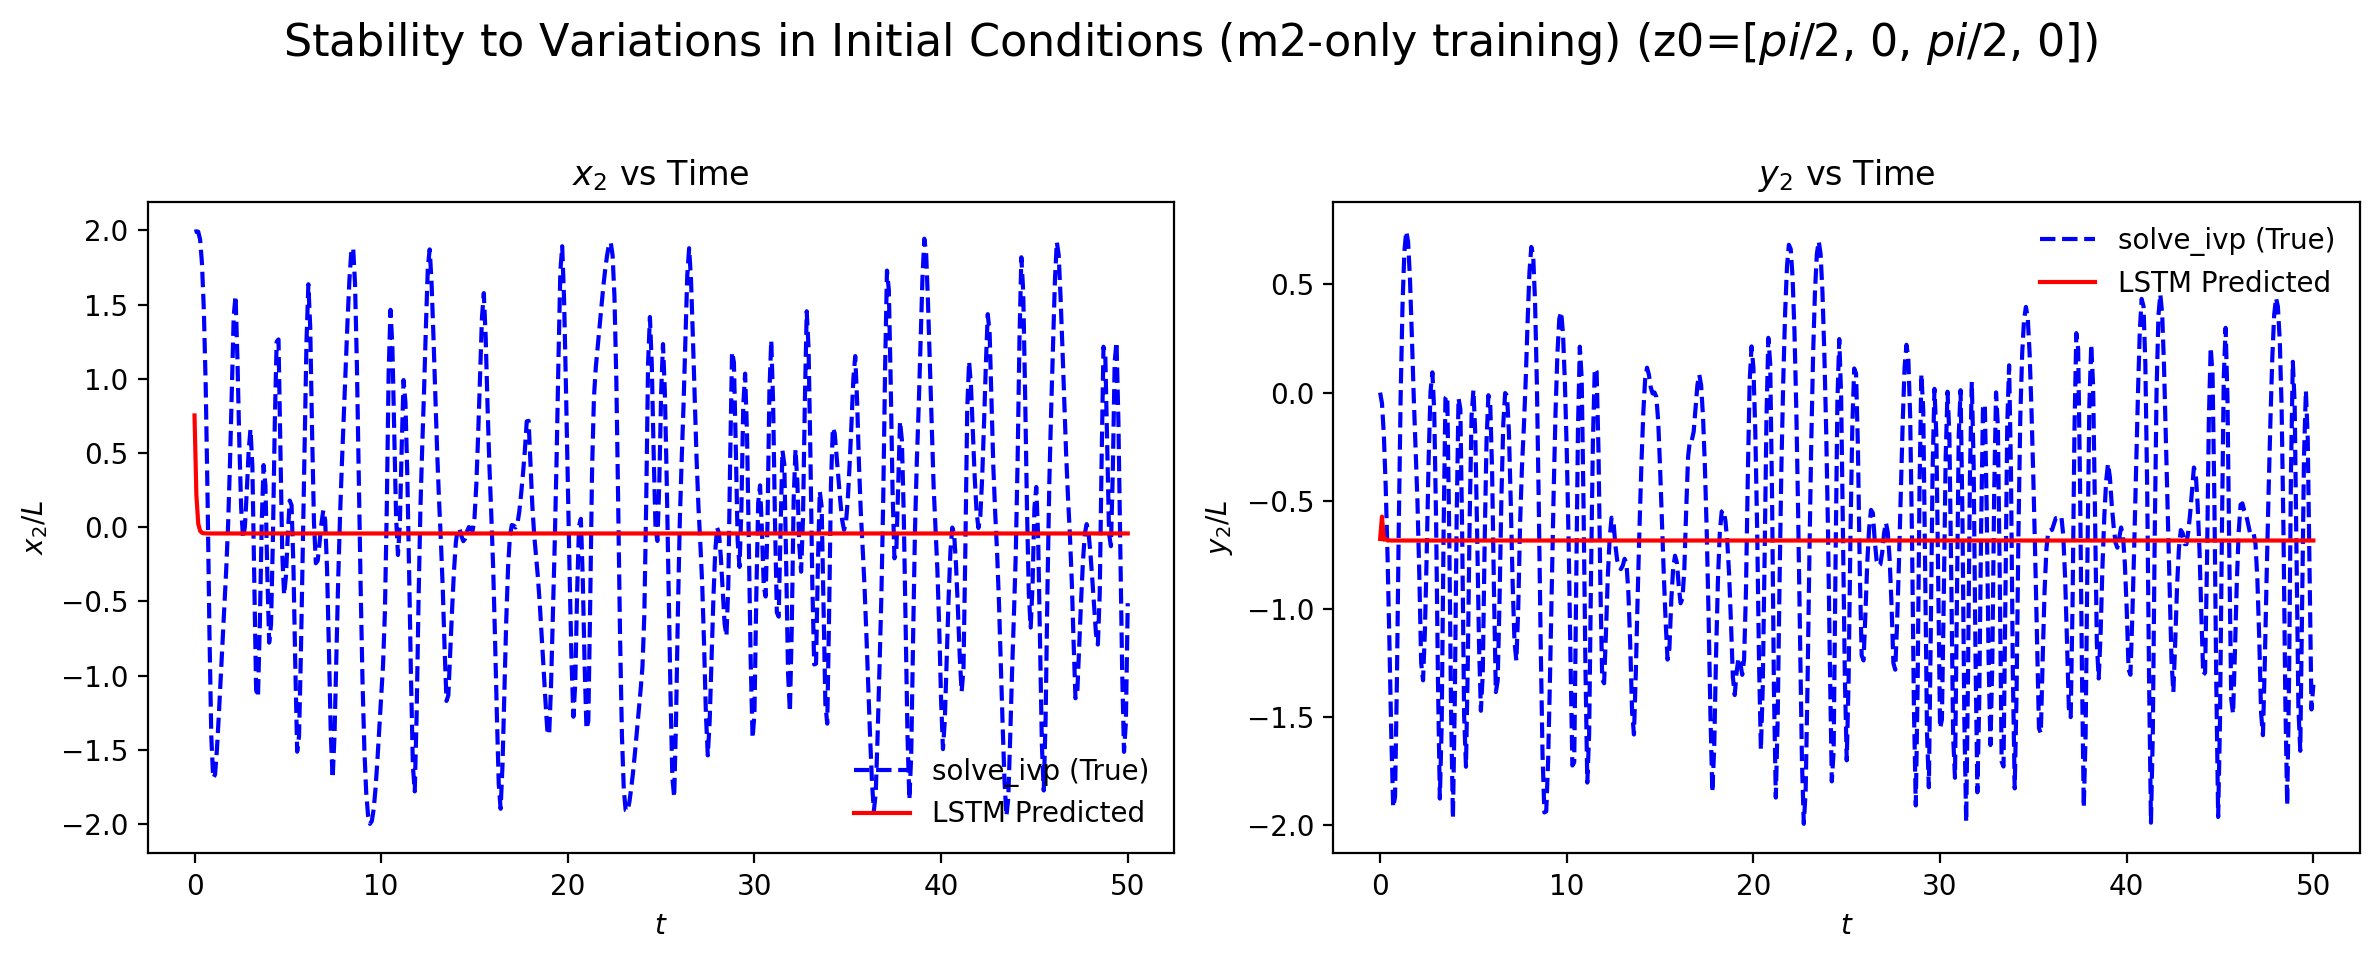


--- Training for future_step = 20 (m2-only) ---
future_step: 20, RMSE Deviation (m2-only): 0.7041

--- Training for future_step = 30 (m2-only) ---
future_step: 30, RMSE Deviation (m2-only): 0.8051

--- Training for future_step = 40 (m2-only) ---
future_step: 40, RMSE Deviation (m2-only): 1.3001

--- Training for future_step = 50 (m2-only) ---
future_step: 50, RMSE Deviation (m2-only): 0.4623

--- Training for future_step = 60 (m2-only) ---
future_step: 60, RMSE Deviation (m2-only): 1.5071

--- Training for future_step = 70 (m2-only) ---
future_step: 70, RMSE Deviation (m2-only): 1.2120

--- Training for future_step = 80 (m2-only) ---
future_step: 80, RMSE Deviation (m2-only): 0.5804

--- Training for future_step = 90 (m2-only) ---
future_step: 90, RMSE Deviation (m2-only): 0.4485

--- Training for future_step = 100 (m2-only) ---
future_step: 100, RMSE Deviation (m2-only): 0.4812


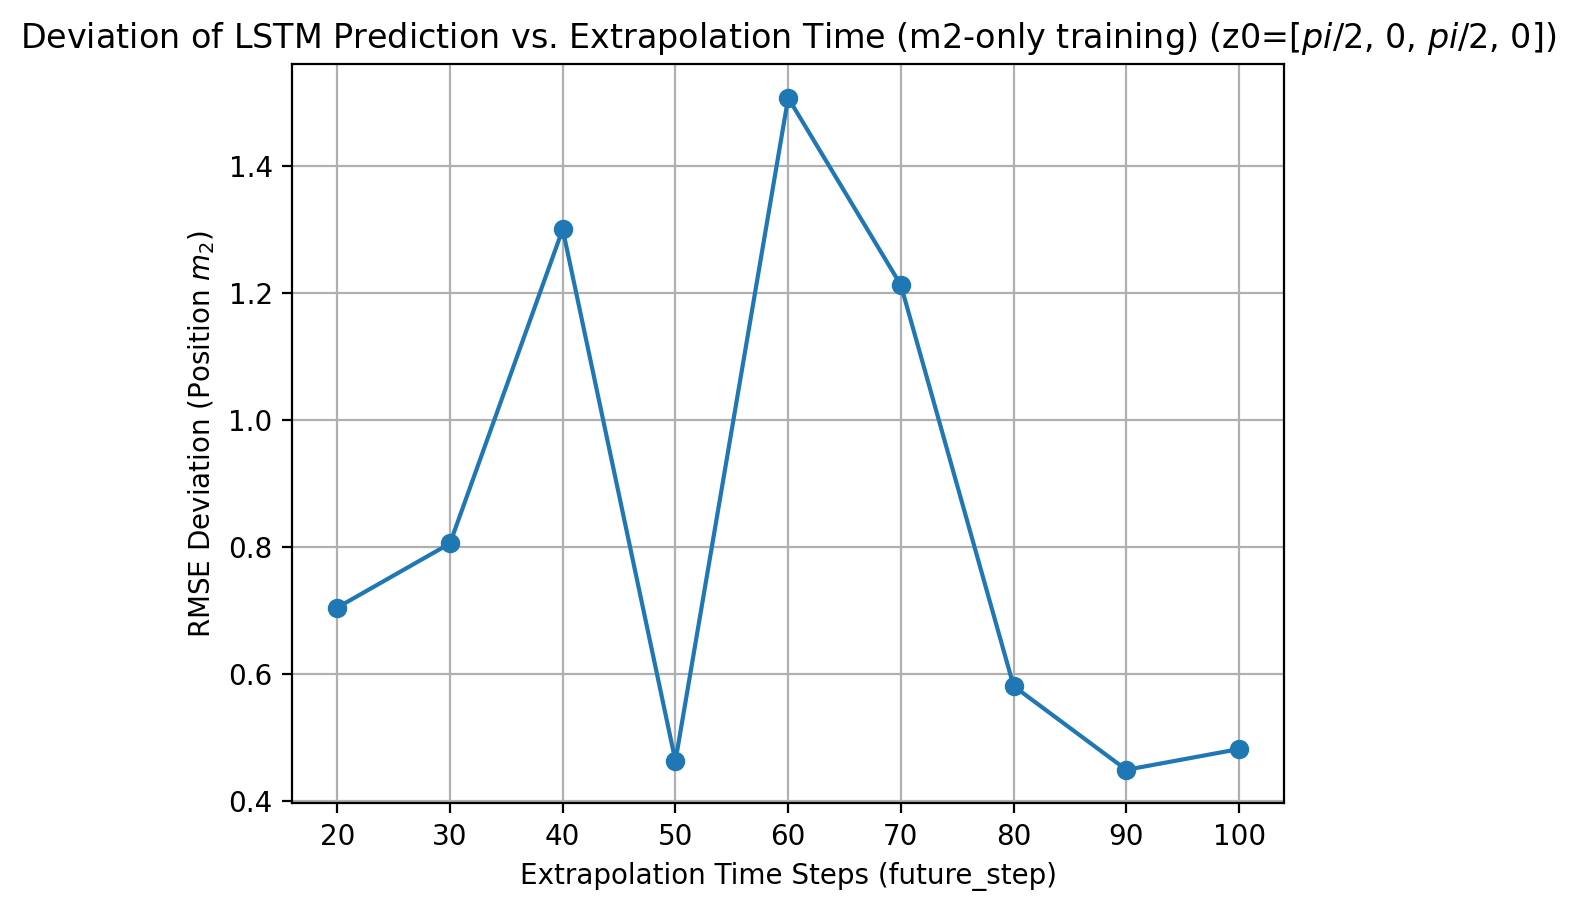

In [ ]:
# Redo question 4 - use pi/2 initial condition

# Parameters setup
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81
z0 = [np.pi/2, 0, np.pi/2, 0] # New initial condition
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)
sequence_length = 1

# Question 1: Design and train RNN

# Generate training data (using both masses for simulation, but only m2 for training)
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z=ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1_data, y1_data, x2_data, y2_data = to_cartesian(theta1, w1, theta2, w2, L1, L2)
cartesian_data_full = np.stack([x1_data, y1_data, x2_data, y2_data], axis=1) # Keep full data for plotting/comparison
cartesian_data_m2_only = np.stack([x2_data, y2_data], axis=1) # Training data: only m2 coordinates

# Prepare data for LSTM - using only m2 coordinates
future_step = 20 # Fixed future step for training in Question 5
input_features = 2 # Only x2, y2 for input
output_features = 2 # Only predict x2, y2
X_train = []
y_train = []
for i in range(0, len(cartesian_data_m2_only) - sequence_length - future_step):
    X_train.append(cartesian_data_m2_only[i:i+sequence_length])
    y_train.append(cartesian_data_m2_only[i+sequence_length+future_step])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, input_features))

# Build LSTM model - input and output dimensions adjusted for m2 only
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, input_features)))
model.add(Dense(output_features)) # Output layer with 2 units (x2, y2)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make a prediction - using only m2 initial condition
last_input_m2_only = cartesian_data_m2_only[-sequence_length:].reshape((1, sequence_length, input_features))
predicted_future_position_m2_only = model.predict(last_input_m2_only, verbose=0)

print("Predicted future position (x2, y2) at t = t0 + 20*dt (m2-only training): (z0=[$pi/2$, 0, $pi/2$, 0])", predicted_future_position_m2_only)

# Plotting
fig,ax=plt.subplots()
ax.plot(x2_data, y2_data, label=r"Track $m_2$ (Simulated)") # Plot only m2 track
ax.plot([x2_data[0]], [y2_data[0]], "o", label="Initial position $m_2$", c='k') # Initial position of m2
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()
plt.title('Track $m_2$ (LSTM trained on $m_2$ coordinates only)')
plt.show()


# Question 2: Stability to variations in initial conditions (m2-only training)

# Perturbed Initial Conditions
z0_perturbed = [np.pi/2 + 0.1, 0, np.pi/2 - 0.1, 0] # Perturb the new initial condition

# Solve_ivp solution with perturbed IC (True trajectory - for m2 only)
ret_perturbed = solve_ivp(rhs, (0, tmax), z0_perturbed, t_eval=t, args=(L1, L2, m1, m2, g), method='RK45')
z_perturbed = ret_perturbed.y
theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed = z_perturbed[0], z_perturbed[1], z_perturbed[2], z_perturbed[3]
x1_true_perturbed, y1_true_perturbed, x2_true_perturbed, y2_true_perturbed = to_cartesian(theta1_perturbed, w1_perturbed, theta2_perturbed, w2_perturbed, L1, L2)
x2_true_perturbed_m2_only = x2_true_perturbed
y2_true_perturbed_m2_only = y2_true_perturbed # True m2 trajectory for perturbed IC

# LSTM Prediction with perturbed IC (m2-only training)
initial_cartesian_perturbed = to_cartesian(z0_perturbed[0], z0_perturbed[1], z0_perturbed[2], z0_perturbed[3], L1, L2)
initial_cartesian_perturbed_m2_only = (initial_cartesian_perturbed[2], initial_cartesian_perturbed[3]) # Only m2 coords
initial_input_perturbed_m2_only = np.array([initial_cartesian_perturbed_m2_only]).reshape((1, output_features)) # Use output_features which is 2
lstm_input_perturbed_m2_only = initial_input_perturbed_m2_only.reshape((1, sequence_length, input_features)) # Use input_features which is 2

x2_predicted_perturbed_list_m2_only = []
y2_predicted_perturbed_list_m2_only = []


current_input_m2_only = lstm_input_perturbed_m2_only.copy()

for _ in range(len(t)):
    predicted_output_m2_only = model.predict(current_input_m2_only, verbose=0)
    x2_predicted_perturbed_list_m2_only.append(predicted_output_m2_only[0][0])
    y2_predicted_perturbed_list_m2_only.append(predicted_output_m2_only[0][1])
    current_input_m2_only = predicted_output_m2_only.reshape((1, sequence_length, input_features))

x2_predicted_perturbed_m2_only = np.array(x2_predicted_perturbed_list_m2_only)
y2_predicted_perturbed_m2_only = np.array(y2_predicted_perturbed_list_m2_only)


# Plotting for Stability Analysis (m2-only)
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) # Reduced to 1x2 subplots
fig.suptitle('Stability to Variations in Initial Conditions (m2-only training) (z0=[$pi/2$, 0, $pi/2$, 0])', fontsize=16)

axs[0].plot(t, x2_true_perturbed_m2_only, label='solve_ivp (True)', color='blue', linestyle='--')
axs[0].plot(t, x2_predicted_perturbed_m2_only, label='LSTM Predicted', color='red')
axs[0].set_ylabel(r"$x_2/L$")
axs[0].set_xlabel(r"$t$")
axs[0].set_title(r"$x_2$ vs Time")
axs[0].legend()

axs[1].plot(t, y2_true_perturbed_m2_only, label='solve_ivp (True)', color='blue', linestyle='--')
axs[1].plot(t, y2_predicted_perturbed_m2_only, label='LSTM Predicted', color='red')
axs[1].set_ylabel(r"$y_2/L$")
axs[1].set_xlabel(r"$t$")
axs[1].set_title(r"$y_2$ vs Time")
axs[1].legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Question 3: How far into the future can the network predict? (m2-only)

# Generate "future" true data for comparison (longer simulation)
max_future_step = 100 # Maximum extrapolation time considered
tmax_long = tmax + max_future_step * dt
t_long = np.arange(0, tmax_long + dt, dt)
ret_long = solve_ivp(rhs, (0, tmax_long), z0, t_eval=t_long, args=(L1, L2, m1, m2, g), method='RK45')
z_long = ret_long.y
theta1_long, w1_long, theta2_long, w2_long = z_long[0], z_long[1], z_long[2], z_long[3]
x1_data_long, y1_data_long, x2_data_long, y2_data_long = to_cartesian(theta1_long, w1_long, theta2_long, w2_long, L1, L2)
cartesian_data_long_m2_only = np.stack([x2_data_long, y2_data_long], axis=1) # Long true data for m2 only


future_step_values = range(20, 101, 10) # Extrapolation times to test
deviation_rmse_values_m2_only = []

for future_step in future_step_values:
    print(f"\n--- Training for future_step = {future_step} (m2-only) ---")

    # Prepare training data for current future_step (m2-only)
    X_train = []
    y_train = []
    for i in range(0, len(cartesian_data_m2_only) - sequence_length - future_step):
        X_train.append(cartesian_data_m2_only[i:i+sequence_length])
        y_train.append(cartesian_data_m2_only[i+sequence_length+future_step])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, input_features)) # Use input_features=2

    # Build and train LSTM model (new model for each future_step, m2-only)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, input_features))) # Use input_features=2
    model.add(Dense(output_features)) # Use output_features=2
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Train silently

    # Make prediction for future position (extrapolation) - m2-only input
    last_input_m2_only = cartesian_data_m2_only[-sequence_length:].reshape((1, sequence_length, input_features)) # Use input_features=2
    predicted_future_position_m2_only = model.predict(last_input_m2_only, verbose=0)

    # Get actual position from the longer simulation (m2-only true data)
    actual_future_position_m2_only = cartesian_data_long_m2_only[len(cartesian_data_m2_only) + future_step -1] # Index into long m2-only data

    # Calculate RMSE deviation (m2-only)
    rmse = np.sqrt(mean_squared_error(actual_future_position_m2_only, predicted_future_position_m2_only[0]))
    deviation_rmse_values_m2_only.append(rmse)
    print(f"future_step: {future_step}, RMSE Deviation (m2-only): {rmse:.4f}")


# Plotting deviation vs extrapolation time (m2-only)
plt.figure()
plt.plot(future_step_values, deviation_rmse_values_m2_only, marker='o')
plt.title('Deviation of LSTM Prediction vs. Extrapolation Time (m2-only training) (z0=[$pi/2$, 0, $pi/2$, 0])')
plt.xlabel('Extrapolation Time Steps (future_step)')
plt.ylabel('RMSE Deviation (Position $m_2$)')
plt.xticks(future_step_values)
plt.grid(True)
plt.show()